In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests as rqs
from bs4 import BeautifulSoup
from IPython.display import clear_output
from time import sleep
from datetime import datetime

def single_team(df) :
    if len(df) == 1: # If player played for a single team, do nothing
        return df
    else: # If player has moved, return total stats with last team
        row = df[df['Tm'] == 'TOT'].copy()
        row['Tm'] = [str(df['Tm'].iloc[-1])]
        return row

def SoRareScore(df):

    df = df.apply(pd.to_numeric, errors = 'ignore')
    scores = []
    for pts, reb, ast, blk, stl, tov, fg_3 in zip(df['PTS'], df['TRB'], df['AST'], df['BLK'], df['STL'], df['TOV'], df['3P']) :
        
        score = 0
        if pts not in ['Inactive', 'Did Not Play', 'Did Not Dress', 'Not With Team', 'Player Suspended']:
            
            pts, reb, ast, blk, stl, tov, fg_3 = int(pts), int(reb), int(ast), int(blk), int(stl), int(tov), int(fg_3)

            score = 1 * pts + 1.2 * reb + 1.5 * ast + 3 * blk + 3 * stl + 1 * fg_3 - 2 * tov

            doubles = 0 # Count double-digits stats
            if pts >= 10 :
                doubles += 1
            if reb >= 10 :
                doubles += 1
            if ast >= 10 :
                doubles += 1
            if blk >= 10 :
                doubles += 1
            if stl >= 10 :
                doubles += 1

            if doubles == 2 : # Double-double
                score += 1

            if doubles >= 3 : # Tripe-double
                score += 2
        
        else :
            score = 'dnp'

        scores.append(score)
    return scores

def mins_played(str) :
    min, sec = str.split(':')
    return float(min) + float(sec) / 60

In [10]:
# Get list of player hrefs
url = f'https://www.basketball-reference.com/leagues/NBA_2023_per_game.html'
page = rqs.get(url)
soup = BeautifulSoup(page.content, 'html')
while soup.find('tr', class_ = 'thead') is not None :
    soup.find('tr', class_ = 'thead').decompose()

table = soup.find('table')
data_live = pd.read_html(str(table))[0]
del data_live['Rk']
hrefs = []
for x in table.find_all('a', href = True):
    if x['href'].split('/')[1] == 'players' :
        hrefs.append(x['href'][:-5])
data_live['href'] = hrefs
data_live = data_live.groupby('Player').apply(single_team)
data_live = data_live.sort_values('PTS', ascending = False).reset_index(drop = True)

data_live.head(10)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,href
0,Joel Embiid,C,28,PHI,21,21,35.9,10.8,20.4,0.529,...,1.7,8.2,9.9,4.6,1.2,1.5,4.1,3.1,33.0,/players/e/embiijo01
1,Luka Dončić,PG,23,DAL,28,28,36.3,11.1,22.4,0.494,...,0.8,7.4,8.3,8.6,1.6,0.6,3.6,2.9,32.5,/players/d/doncilu01
2,Shai Gilgeous-Alexander,SG,24,OKC,28,28,35.7,10.4,20.8,0.501,...,0.8,3.8,4.6,5.8,1.7,1.0,3.4,2.6,31.3,/players/g/gilgesh01
3,Giannis Antetokounmpo,PF,28,MIL,25,25,32.8,11.1,20.9,0.533,...,2.0,9.1,11.1,5.2,0.8,1.0,3.6,3.6,31.0,/players/a/antetgi01
4,Kevin Durant,PF,34,BRK,30,30,36.7,10.9,19.2,0.565,...,0.3,6.3,6.6,5.3,0.7,1.6,3.6,2.4,30.4,/players/d/duranke01
5,Jayson Tatum,PF,24,BOS,29,29,37.0,9.9,21.1,0.470,...,1.2,7.0,8.2,4.1,1.1,0.9,2.8,2.2,30.2,/players/t/tatumja01
6,Stephen Curry,PG,34,GSW,26,26,34.4,10.1,20.2,0.500,...,0.6,6.0,6.6,6.8,1.0,0.3,3.1,2.1,30.0,/players/c/curryst01
7,Donovan Mitchell,SG,26,CLE,28,28,36.4,10.3,20.4,0.506,...,0.9,2.9,3.8,4.4,1.3,0.4,3.0,2.6,29.3,/players/m/mitchdo01
8,Damian Lillard,PG,32,POR,19,19,34.7,8.5,18.6,0.455,...,0.6,3.2,3.8,7.0,0.8,0.2,3.6,1.8,28.3,/players/l/lillada01
9,Devin Booker,SG,26,PHO,28,28,35.6,10.1,21.1,0.477,...,0.8,4.0,4.8,5.8,0.9,0.4,2.5,2.8,28.0,/players/b/bookede01


In [11]:
data_live['SORARE'] = SoRareScore(data_live)

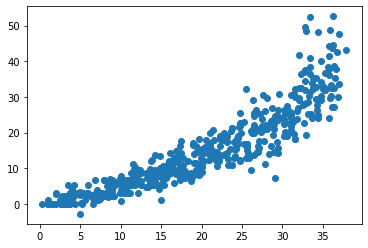

In [15]:
plt.scatter(data_live.MP, data_live.SORARE)

In [37]:
data = data_live[(data_live['SORARE'] >= 30) & (data_live['SORARE'] < 35) & (data_live['G'] >= 10)]
data['S_mp'] = data['SORARE'] / data['MP']
data.sort_values('SORARE', ascending=False).head(25)

/var/folders/x8/gymrgfns32bd6rd_ksf19p3m0000gn/T/ipykernel_72260/3853952739.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['S_mp'] = data['SORARE'] / data['MP']


,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,TRB,AST,STL,BLK,TOV,PF,PTS,href,SORARE,S_mp
55,Jrue Holiday,PG,32,MIL,23,22,32.8,7.3,15.8,0.459,...,5.2,7.6,1.5,0.4,3.2,1.9,19.2,/players/h/holidjr01,34.5,1.051829
23,Bradley Beal,SG,29,WAS,19,19,34.8,8.7,16.6,0.522,...,3.6,5.3,1.1,0.6,2.8,1.9,23.2,/players/b/bealbr01,34.1,0.979885
20,Desmond Bane,SG,24,MEM,12,12,33.6,8.3,17.8,0.465,...,4.9,4.8,0.6,0.3,2.3,2.4,24.7,/players/b/banede01,33.8,1.005952
58,Fred VanVleet,PG,28,TOR,25,25,37.0,6.0,15.7,0.379,...,3.9,6.2,1.6,0.5,1.9,2.8,18.7,/players/v/vanvlfr01,33.6,0.908108
47,Darius Garland,PG,23,CLE,26,26,36.0,7.1,16.5,0.430,...,2.7,8.0,1.4,0.2,3.3,2.0,20.6,/players/g/garlada01,33.4,0.927778
39,Tyler Herro,SG,23,MIA,23,23,34.9,7.5,16.3,0.457,...,6.3,4.2,0.9,0.5,2.7,1.7,21.2,/players/h/herroty01,33.2,0.951289
35,Zach LaVine,SG,27,CHI,25,25,34.2,7.9,17.8,0.443,...,4.4,4.1,1.2,0.0,2.6,2.4,21.8,/players/l/lavinza01,32.8,0.959064
22,Anfernee Simons,SG,23,POR,29,29,36.0,8.2,18.3,0.448,...,3.0,4.2,0.8,0.2,2.2,2.4,23.2,/players/s/simonan01,32.6,0.905556
27,Tyrese Maxey,SG,22,PHI,15,15,36.4,8.4,18.2,0.462,...,3.5,4.4,1.0,0.3,2.0,2.3,22.9,/players/m/maxeyty01,32.6,0.895604
30,Lauri Markkanen,SF,25,UTA,30,30,33.8,7.9,14.9,0.529,...,8.3,2.2,0.6,0.6,2.1,2.2,22.3,/players/m/markkla01,32.6,0.964497


In [30]:
data = data_live[(data_live['PTS'] >= 7) & (data_live['PTS'] <= 12)]
features = ['form_1', 'form_2', 'form_5', 'form_10', 'mean_score']
players_info = []
for player, href in zip(data['Player'], data['href']) :
    clear_output(wait = True)
    print(f'Fetching {player} games ...')
    url = f'https://www.basketball-reference.com{href}/gamelog/2023'

    page = rqs.get(url)
    soup = BeautifulSoup(page.content, 'html')
    while soup.find('tr', class_ = 'thead') is not None :
        soup.find('tr', class_ = 'thead').decompose()

    table = soup.find('table', id = 'pgl_basic')
    df = pd.read_html(str(table))[0][['Date', 'Tm', 'G', 'MP', 'PTS', 'TRB', 'AST', 'BLK', 'STL', 'TOV', '3P']]
    df.insert(0, 'Player', len(df) * [player])
    df = df.apply(pd.to_numeric, errors = 'ignore')
    df['SORARE'] = SoRareScore(df)
    df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
    df = df.sort_values('Date')
    df['SORARE'] = df['SORARE'].replace('dnp', np.nan)

    df_past = df[df['Player'].notna()]
    df_pred = df[df['Player'].isna()]

    form_1 = df_past['SORARE'].tail(1).mean()
    form_2 = df_past['SORARE'].tail(2).mean()
    form_5 = df_past['SORARE'].tail(5).mean()
    form_10 = df_past['SORARE'].tail(10).mean()
    if (df_past['SORARE'].tail(10).isna()).sum() == 10:
        cost = np.nan
    else:
        df_cost = df_past[df_past['SORARE'].notna()]
        cost = round(df_cost['SORARE'].tail(10).mean())
    form_25 = df_past['SORARE'].tail(25).mean()
    stdev = df_past['SORARE'].std()
    
    player_form = pd.DataFrame([[player, cost, stdev,  form_1, form_2, form_5, form_10, form_25]],
                                            columns = ['Player', 'Cost', 'Std.'] + features)

    players_info.append(player_form)
    sleep(2)
    
my_data = pd.concat(players_info).reset_index(drop = True)

Fetching Josh Green games ...


In [36]:
test = pd.concat(players_info).reset_index(drop = True).sort_values('Std.', ascending = False)

Ivica Zubac
Kevin Love
Cam Reddish
Jevon Carter
Jaden McDaniels
Bruce Brown
Steven Adams
Derrick White
Marvin Bagley III
Tre Mann
Isaiah Jackson
Nick Richards
Draymond Green
Herbert Jones
Royce O'Neale
Mike Conley
Jeremy Sochan
Gabe Vincent
Obi Toppin
Isaiah Stewart


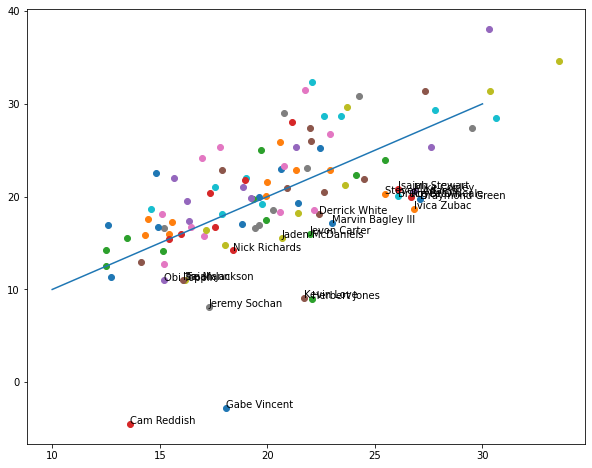

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 8))
for x, y, player in zip(test.mean_score, test.form_5, test.Player):
    plt.scatter(x, y)
    if x - y > 4:
        plt.annotate(player, xy = (x, y))
        print(player)

plt.plot([10, 30], [10, 30])

In [32]:
url = f'https://www.soraredata.com/rankings'

page = rqs.get(url)
soup = BeautifulSoup(page.content, 'html')

soup


<!DOCTYPE html>
<html lang="en-US">
<head>
<title>Just a moment...</title>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<meta content="IE=Edge" http-equiv="X-UA-Compatible"/>
<meta content="noindex,nofollow" name="robots"/>
<meta content="width=device-width,initial-scale=1" name="viewport"/>
<link href="/cdn-cgi/styles/challenges.css" rel="stylesheet"/>
</head>
<body class="no-js">
<div class="main-wrapper" role="main">
<div class="main-content">
<h1 class="zone-name-title h1">
<img class="heading-favicon" onerror="this.onerror=null;this.parentNode.removeChild(this)" src="/favicon.ico"/>
            www.soraredata.com
        </h1>
<h2 class="h2" id="challenge-running">
            Checking if the site connection is secure
        </h2>
<noscript>
<div id="challenge-error-title">
<div class="h2">
<span class="icon-wrapper">
<div class="heading-icon warning-icon"></div>
</span>
<span id="challenge-error-text">
                        Enable JavaScript and cookies

In [31]:
page = rqs.get(url)
table = page.text.split(f'<div class="table_container current" id="div_per_poss">')[1].split('</table>')[0] + '</table>'
soup = BeautifulSoup(table, 'html')
soup

IndexError: list index out of range